# SAM2 vs SAM3 with a Left-Cat BBox Prompt

Goal: use one bounding box around the **left cat** and compare behavior.
- **SAM2** should stay focused on the prompted left cat.
- **SAM3** may also segment the right cat (same semantic class), which is what we want to visualize.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from transformers import Sam3Model, Sam3Processor


def resolve_path(path_str: str) -> str:
    p = Path(path_str)
    candidates = [
        p,
        Path.cwd() / p,
        Path.cwd().parent / p,
    ]
    for c in candidates:
        if c.exists():
            return str(c)
    return str(p)


# --- Paths / prompt setup ---
# Put your cat image path here (the image with 2 cats).
image_path = resolve_path("cats.jpg")

# xyxy bbox around the LEFT cat on your image.
# Default below is a good starting point for a ~736x1280 image like the one you shared.
left_cat_box = [75, 250, 370, 910]  # [x1, y1, x2, y2]

# Important: for build_sam2, pass only the config NAME, not "sam2_configs/..."
sam2_cfg = "sam2_hiera_l.yaml"
sam2_ckpt = resolve_path("checkpoints/sam2_hiera_large.pt")
sam3_ckpt = "facebook/sam3"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
print(f"Image path: {image_path}")
print(f"SAM2 checkpoint path: {sam2_ckpt}")

/Users/mac/Developer/VScode/no-time-to-train/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu
Image path: cats.jpg
SAM2 checkpoint path: /Users/mac/Developer/VScode/no-time-to-train/checkpoints/sam2_hiera_large.pt


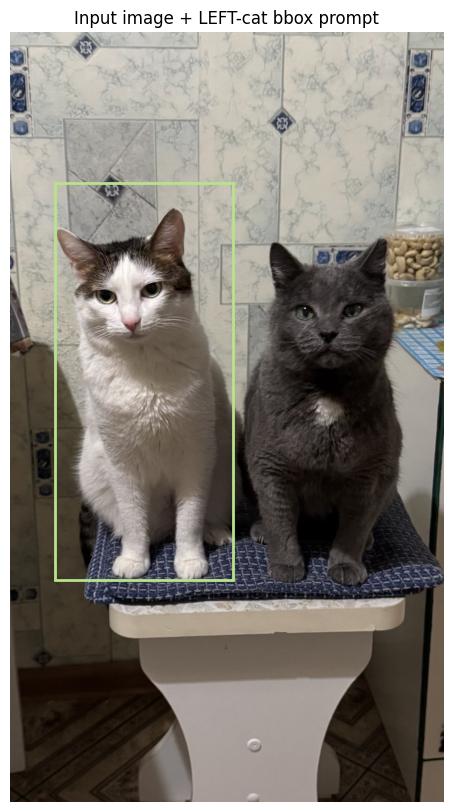

Image size: 720x1280
BBox: [75, 250, 370, 910]


In [3]:
# Load image and visualize the bbox prompt
image_pil = Image.open(image_path).convert("RGB")
image_np = np.array(image_pil)
H, W = image_np.shape[:2]

x1, y1, x2, y2 = left_cat_box

plt.figure(figsize=(6, 10))
plt.imshow(image_np)
plt.gca().add_patch(
    plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="#b9e28c", linewidth=2)
)
plt.title("Input image + LEFT-cat bbox prompt")
plt.axis("off")
plt.show()

print(f"Image size: {W}x{H}")
print(f"BBox: {left_cat_box}")

In [4]:
# SAM2 inference with box prompt
sam2_model = build_sam2(sam2_cfg, sam2_ckpt, device=device)
sam2_predictor = SAM2ImagePredictor(sam2_model)
sam2_predictor.set_image(image_pil)

masks2, scores2, _ = sam2_predictor.predict(
    box=np.array(left_cat_box, dtype=np.float32),
    multimask_output=True,
)

best2_idx = int(np.argmax(scores2))
sam2_mask = masks2[best2_idx] > 0

print(f"SAM2 candidate masks: {len(masks2)}")
print(f"SAM2 best score: {scores2[best2_idx]:.4f}")

SAM2 candidate masks: 3
SAM2 best score: 0.9765


In [5]:
# SAM3 inference with the same box prompt
sam3_processor = Sam3Processor.from_pretrained(sam3_ckpt)
sam3_model = Sam3Model.from_pretrained(sam3_ckpt).to(device)
sam3_model.eval()

inputs3 = sam3_processor(
    images=image_pil,
    input_boxes=[[left_cat_box]],
    input_boxes_labels=[[1]],
    return_tensors="pt",
).to(device)

with torch.no_grad():
    outputs3 = sam3_model(**inputs3)

result3 = sam3_processor.post_process_instance_segmentation(
    outputs3,
    threshold=0.5,
    target_sizes=inputs3["original_sizes"].tolist(),
)[0]

if "masks" in result3 and len(result3["masks"]) > 0:
    sam3_masks = result3["masks"].cpu().numpy().astype(bool)
    sam3_union = np.any(sam3_masks, axis=0)
else:
    sam3_masks = np.zeros((0, H, W), dtype=bool)
    sam3_union = np.zeros((H, W), dtype=bool)

print(f"SAM3 returned masks: {len(sam3_masks)}")

Loading weights: 100%|██████████| 1468/1468 [00:00<00:00, 1622.15it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


SAM3 returned masks: 2


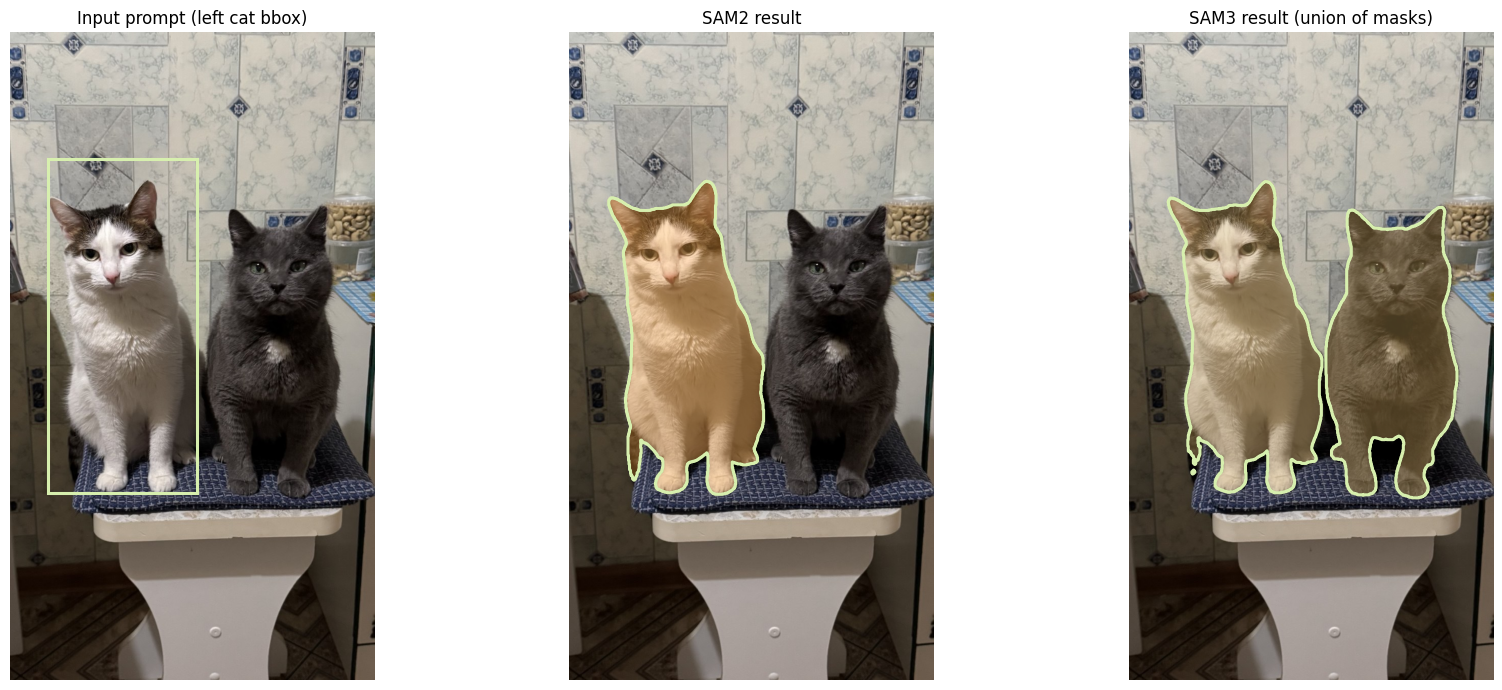

SAM2 mask pixels: 125714
SAM3 mask pixels (union): 230488
SAM3 pixels on right half of image: 112033
✅ SAM3 is also activating on the right side (likely right cat).
Saved bbox image (300 ppi): work_dirs/sam_prompt_bbox_300ppi.png
Saved SAM2 image (300 ppi): work_dirs/sam2_result_300ppi.png
Saved SAM3 image (300 ppi): work_dirs/sam3_result_300ppi.png


In [6]:
# Side-by-side visualization + export 3 separate images (bbox, SAM2, SAM3)
from pathlib import Path


def overlay_mask(img, mask, color=(0, 255, 0), alpha=0.45):
    out = img.astype(np.float32).copy()
    col = np.array(color, dtype=np.float32)
    out[mask] = (1 - alpha) * out[mask] + alpha * col
    return out.astype(np.uint8)


def draw_outline(ax, mask, color="#b9e28c", linewidth=2.2):
    if mask.any():
        ax.contour(mask.astype(float), levels=[0.5], colors=[color], linewidths=linewidth)


def save_panel(view_img, title, out_path, add_bbox=False, add_outline_mask=None):
    fig_local, ax = plt.subplots(1, 1, figsize=(6, 8))
    ax.imshow(view_img)
    if add_bbox:
        ax.add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="#d7efae", linewidth=2.2)
        )
    if add_outline_mask is not None:
        draw_outline(ax, add_outline_mask, color="#d7efae", linewidth=2.2)
    ax.set_title(title)
    ax.axis("off")
    fig_local.tight_layout()
    fig_local.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig_local)


prompt_view = image_np.copy()
sam2_view = overlay_mask(image_np, sam2_mask, color=(255, 170, 70), alpha=0.35)
sam3_view = overlay_mask(image_np, sam3_union, color=(200, 165, 95), alpha=0.35)

# Show combined figure in notebook
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

axes[0].imshow(prompt_view)
axes[0].add_patch(
    plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="#d7efae", linewidth=2.2)
)
axes[0].set_title("Input prompt (left cat bbox)")
axes[0].axis("off")

axes[1].imshow(sam2_view)
draw_outline(axes[1], sam2_mask, color="#d7efae", linewidth=2.2)
axes[1].set_title("SAM2 result")
axes[1].axis("off")

axes[2].imshow(sam3_view)
draw_outline(axes[2], sam3_union, color="#d7efae", linewidth=2.2)
axes[2].set_title("SAM3 result (union of masks)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

# Export 3 separate 300 ppi images
out_dir = Path("work_dirs")
out_dir.mkdir(parents=True, exist_ok=True)

bbox_path = out_dir / "sam_prompt_bbox_300ppi.png"
sam2_path = out_dir / "sam2_result_300ppi.png"
sam3_path = out_dir / "sam3_result_300ppi.png"

save_panel(
    prompt_view,
    "Input prompt (left cat bbox)",
    bbox_path,
    add_bbox=True,
)
save_panel(
    sam2_view,
    "SAM2 result",
    sam2_path,
    add_outline_mask=sam2_mask,
)
save_panel(
    sam3_view,
    "SAM3 result (union of masks)",
    sam3_path,
    add_outline_mask=sam3_union,
)

right_half_overlap = int((sam3_union[:, W // 2:] > 0).sum())
print(f"SAM2 mask pixels: {int(sam2_mask.sum())}")
print(f"SAM3 mask pixels (union): {int(sam3_union.sum())}")
print(f"SAM3 pixels on right half of image: {right_half_overlap}")
if right_half_overlap > 0:
    print("✅ SAM3 is also activating on the right side (likely right cat).")
else:
    print("ℹ️ SAM3 is not activating on the right side with this bbox/threshold.")
print(f"Saved bbox image (300 ppi): {bbox_path}")
print(f"Saved SAM2 image (300 ppi): {sam2_path}")
print(f"Saved SAM3 image (300 ppi): {sam3_path}")